<a href="https://colab.research.google.com/github/Jessicangelinet/try-CSI-Activity-Recognition/blob/master/%5BJes%5DFYP_CNN_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
import torchvision.transforms as transforms
import torchvision.io as io

from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from google.colab import drive

np.random.seed(123)

In [3]:
# Mount Google Drive to import dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set the path of the dataset
# dataset_path = "/content/drive/My Drive/sample_dataset_image_front"
dataset_path = "/content/drive/My Drive/FYP_2025/FYP/Amplitude/image_filtered/front"
classes = os.listdir(dataset_path)
print(classes)

['clap', 'jump', 'nopeople', 'punching', 'pushpull', 'rubhand', 'squatting', 'standing', 'twist', 'waving']


In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is not available.  Training on CPU ...


In [7]:
#can delete this?
# Dataset class to get dataset from Google Drive and convert to tensor accordingly
class HARDataset(Dataset):
    def __init__(self, root_dir, target_size=(256, 256), transform=None, subset="training"):
        self.root_dir = root_dir
        self.target_size = target_size  # Standardized image size
        self.transform = transform

        # Creates list of class folders
        self.class_folders = os.listdir(root_dir)
        self.class_to_label = {class_name: idx for idx, class_name in enumerate(self.class_folders)}

        self.file_list = []
        for class_name in self.class_folders:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                csv_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.csv')]
                self.file_list.extend([(csv, self.class_to_label[class_name]) for csv in csv_files])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        data = pd.read_csv(file_path).values

        # Ensure 2D shape (handle different input sizes)
        if len(data.shape) == 1:  # If flat, assume it's a row vector
            data = data.reshape(1, -1)  # Convert to (1, N)
        h, w = data.shape

        # Convert to tensor and resize
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # (1, H, W) for grayscale
        resize_transform = transforms.Resize(self.target_size)  # Resize to fixed (H, W)
        data = resize_transform(data)  # Resize tensor

        return data, torch.tensor(label, dtype=torch.long)

In [8]:
# FOR IMAGE
# Dataset class to get dataset from Google Drive and convert to tensor accordingly

class HARDataset(Dataset):
    def __init__(self, root_dir, target_size=(256, 256), transform=None, subset="training"):
        self.root_dir = root_dir
        self.target_size = target_size  # Standardized image size
        self.transform = transform
        self.grayscale_transform = transforms.Grayscale(num_output_channels=1)

        # Creates list of class folders
        self.class_folders = os.listdir(root_dir)
        self.class_to_label = {class_name: idx for idx, class_name in enumerate(self.class_folders)}

        self.file_list = []
        for class_name in self.class_folders:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                csv_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.png')]
                self.file_list.extend([(csv, self.class_to_label[class_name]) for csv in csv_files])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]

        image = io.read_image(file_path, mode=io.image.ImageReadMode.GRAY)

        # if self.transform:
        #     image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [9]:
# Function to split the dataset into training, validation and testing
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1, "Splits must sum to 1"

    total_size = len(dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size  # Ensure the remainder goes to test

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] range
])

In [12]:
image_shape = (300, 114)  # Adjust based on CSV dimensions
batch_size = 50

dataset = HARDataset(dataset_path, image_shape, transform=transform)

training_dataset, validation_dataset, test_dataset = split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Check size of each set
print(f"Training set size: {len(training_dataset)}")
print(f"Validation set size: {len(validation_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 9676
Validation set size: 1209
Test set size: 1210


In [14]:
# Verify data loading
for images, labels in train_loader:
    print(images.shape)  # Expected: (batch_size, 1, H, W)
    print(labels.shape)  # Expected: (batch_size,)
    break

torch.Size([50, 1, 300, 114])
torch.Size([50])


In [15]:
# Functions to visualise a batch of training images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = classes
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

In [16]:
# Obtain one batch of training images
dataiter = iter(train_loader) # create an iterator from an iterable object
images, labels = next(dataiter) # retrieves the next item (batch size) from an iterator
images = images.numpy() # convert images to numpy for display

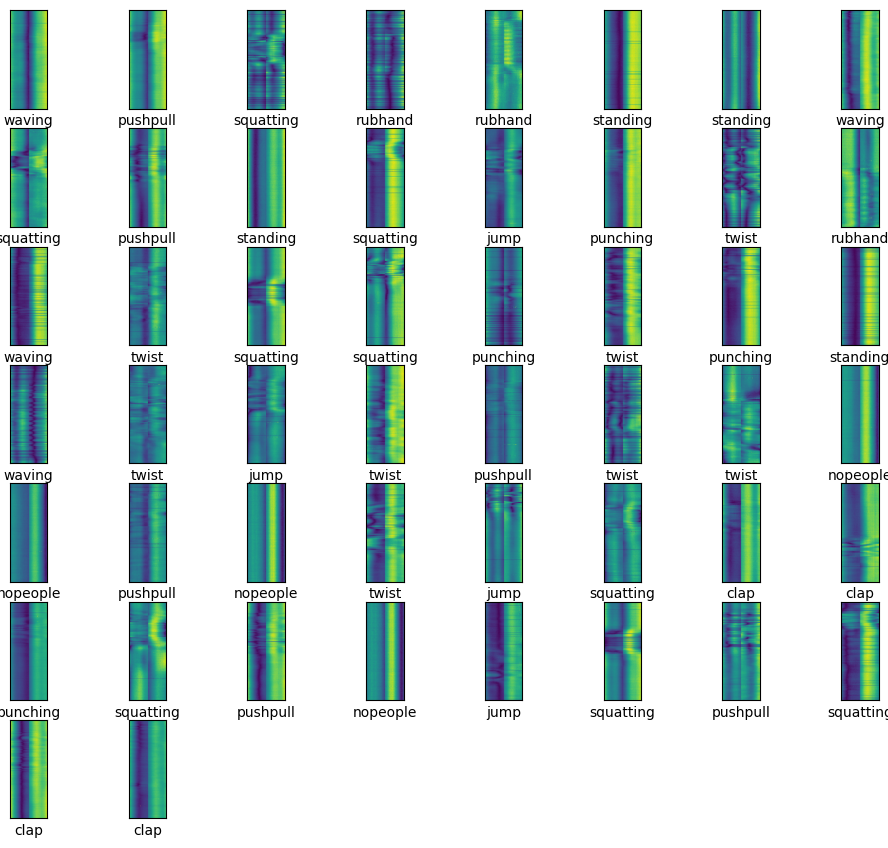

In [17]:
visualize_data(images, labels)

## Model and Training

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):  # Adjust num_classes as needed
        super(CNNModel, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces to (150, 83)

        # Block 2
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces to (75, 41)

        # Block 3
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces to (37, 20)

        # Compute the flattened feature size
        self.flatten_dim = self._get_flatten_dim()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _get_flatten_dim(self):
        """Helper function to compute feature map size after convolutions."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 300, 114)  # Batch size 1, single channel
            x = self.pool1(F.relu(self.bn1(self.conv2(F.relu(self.conv1(dummy_input))))))
            x = self.pool2(F.relu(self.bn2(self.conv4(F.relu(self.conv3(x))))))
            x = self.pool3(F.relu(self.bn3(self.conv6(F.relu(self.conv5(x))))))
            return x.numel()

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv2(F.relu(self.conv1(x))))))
        x = self.pool2(F.relu(self.bn2(self.conv4(F.relu(self.conv3(x))))))
        x = self.pool3(F.relu(self.bn3(self.conv6(F.relu(self.conv5(x))))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation (CrossEntropyLoss applies softmax)
        return x

In [25]:
# Loss and optimizer
cnn_model = CNNModel(len(classes))
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [26]:
def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [27]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

In [28]:
def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device)
  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
      model.train()
      for (X, y) in train_loader:
          # Move input data to the same device as the model
          X,y = X.to(device), y.to(device)
          # Forward pass
          outputs = model(X.type(torch.float32))
          loss = loss_fn(outputs, y.type(torch.long))
          # Backward and optimize
          optim.zero_grad()
          loss.backward()
          optim.step()
      #losses and accuracies for epoch
      val_loss = compute_loss(model, loss_fn, valid_loader)
      val_acc = compute_acc(model, valid_loader)
      train_loss = compute_loss(model, loss_fn, train_loader)
      train_acc = compute_acc(model, train_loader)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      if not verbose: #verbose = True means we do show the training information during training
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

In [ ]:
history = fit(model= cnn_model, train_loader=train_loader, valid_loader = val_loader,
    optimizer = optimizer, num_epochs= 25, verbose = False)

In [ ]:
his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'b--',label='train_loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

ax2 = ax.twinx()
ln3 = ax2.plot(his['train_acc'], 'r--',label='train_accuracy')
ln4 = ax2.plot(his['val_acc'], 'r-',label='val_accuracy')
ax2.set_ylabel('accuracy', color='red')
ax2.tick_params(axis='y', colors="red")

lns = ln1 + ln2 + ln3 + ln4
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

In [ ]:
test_acc = compute_acc(model = cnn_model, loader= test_loader)
print(f"Test acc = {test_acc*100:.2f}%")

In [ ]:
# Evaluate and store the predictions of model
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Generate Confusion Matrix
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# Evaluate and display confusion matrix
true_labels, pred_labels = evaluate_model(cnn_model, test_loader, device)
plot_confusion_matrix(true_labels, pred_labels, classes)

In [ ]:
# Compare the predicted labels and true labels
print(true_labels)
print(pred_labels)

In [ ]:
# Save the model to download
torch.save(cnn_model.state_dict(), "cnn_model_weights.pth")

In [ ]:
# Alternative to directly save into Google Drive
torch.save(cnn_model.state_dict(), '/content/drive/MyDrive/cnn_model_weights_mini_vgg_25_epochs_front.pth')

In [ ]:
# Load the saved weights into the model
loaded_model = CNNModel(len(classes))  # Recreate the model architecture
loaded_model.load_state_dict(torch.load("cnn_model_weights.pth"))
loaded_model.to(device)
loaded_model.eval()  # Set to evaluation mode

In [ ]:
# Test accuracy of loaded model
test_acc = compute_acc(model = loaded_model, loader= test_loader)
print(f"Test acc = {test_acc*100:.2f}%")